In [48]:
!pip install mesa==2.3.1 --quiet

In [49]:
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import BaseScheduler
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import seaborn as sns

In [59]:
class SimAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.actionPoints = 4
        self.savedAP = 0
        self.isCarryingVictim = False
        self.victimsRescued = 0
        self.isKnockedOut = False
        self.closestExit = None
        self.closestPoi = None

    def can_move(self, direction):
        print("Verificando movimientos")
        x, y = self.pos
        walls = self.model.walls[x][y]  # Obtener las paredes de la celda actual

        if direction == "up" and walls[0] == 0:
            return True
        if direction == "down" and walls[2] == 0:
            return True
        if direction == "left" and walls[1] == 0:
            return True
        if direction == "right" and walls[3] == 0:
            return True
        return False

    def findClosestExit(self):
        print("Buscando salida")
        closest_exit = None
        min_distance = float('inf')
        for exit_pos in self.model.exitPos:
            distance = abs(self.pos[0] - exit_pos[0]) + abs(self.pos[1] - exit_pos[1])
            if distance < min_distance:
                min_distance = distance
                closest_exit = exit_pos
        print(closest_exit)
        self.closestExit = closest_exit

    def findClosestPoi(self):
        print("Buscando POI")

        if not self.model.POI:
            print("No más POIs, checar si acabó el juego")
            return

        closest_poi = None
        min_distance = float('inf')
        for poi in self.model.POI:
            distance = abs(self.pos[0] - poi[0]) + abs(self.pos[1] - poi[1])
            if distance < min_distance:
                min_distance = distance
                closest_poi = poi
        print(closest_poi)
        self.closestPoi = closest_poi

    def extinguish(self):
        print("Extinguiendo")
        cell_status = self.model.cells[self.pos]
        if cell_status == 2:  # Fuego
            self.model.cells[self.pos] = 0  # Convertir a humo
            self.actionPoints -= 2
            return
        elif cell_status == 1:  # Humo
            self.model.cells[self.pos] = 0  # Eliminar humo
            self.actionPoints -= 1
            return

        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        for neighbor in neighbors:
            if self.actionPoints <= 0:
                break
            cell_status = self.model.cells[neighbor]
            if cell_status == 2:  # Fuego
                self.model.cells[neighbor] = 1  # Convertir a humo
                self.actionPoints -= 2
                break
            elif cell_status == 1:  # Humo
                self.model.cells[neighbor] = 0  # Eliminar humo
                self.actionPoints -= 1
                break


    def turnToSmoke(self):
        print("Convirtiendo en humo")
        cell_status = self.model.cells[self.pos]
        if cell_status == 2:  # Fuego
            self.model.cells[self.pos] = 1  # Convertir a humo
            self.actionPoints -= 1
            return

        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        for neighbor in neighbors:
            if self.actionPoints <= 0:
                break
            cell_status = self.model.cells[neighbor]
            if cell_status == 2:  # Fuego
                self.model.cells[neighbor] = 1  # Convertir a humo
                self.actionPoints -= 1
                break

    def rescue(self):
        """
        Verifica y maneja el POI en la celda actual.
        """
        print("Rescatando/verificando POI")
        for poi in self.model.POI:
            if (self.pos[0], self.pos[1]) == (poi[0], poi[1]):
                if poi[2] == 'v':  # Es una víctima
                    self.isCarryingVictim = True
                    self.model.POI.remove(poi)  # Eliminar el POI del modelo
                    self.model.cells[self.pos] = 0
                    print("Rescató una víctima.")
                    self.findClosestPoi
                    self.findClosestExit
                    return True
                elif poi[2] == 'f':  # Es una falsa alarma
                    self.model.POI.remove(poi)  # Eliminar el POI del modelo
                    self.model.cells[self.pos] = 0
                    print("Encontró una falsa alarma.")
                    self.findClosestPoi
                    self.findClosestExit
                    return False
                return False


    def moveTowards(self, target):
        print("Moving towards")
        x_diff = target[0] - self.pos[0]
        y_diff = target[1] - self.pos[1]
        new_x = self.pos[0] + (1 if x_diff > 0 else -1 if x_diff < 0 else 0)
        new_y = self.pos[1] + (1 if y_diff > 0 else -1 if y_diff < 0 else 0)
        new_pos = (new_x, new_y)


        if self.isCarryingVictim and self.model.cells[new_pos] == 2:
          print("No pudo moverse")
          return False


        if self.model.cells[self.pos] == 3:
          self.rescue()

        if self.model.grid.is_cell_empty(new_pos): #and self.can_move("right"): # Requiere de dirección, right es un placeholder -------------------------------------
            self.model.grid.move_agent(self, new_pos)
            self.actionPoints -= 1

            if self.isCarryingVictim:
              self.actionPoints -= 1

            if self.model.cells[self.pos] == 2:
              self.actionPoints -= 1

            if self.rescue():
              self.findClosestExit()
              return True
            if self.model.cells[new_pos] == 2:
              self.turnToSmoke()
            print("pudo moverse")
            return True

        else:
          print(f"No pudo moverse pq {self.model.grid.is_cell_empty(new_pos)}, o {self.model.cells[new_pos]}. La posición fue {new_pos}")
          print(f"Su posición es: {self.pos}")

          if self.wiggle():
            return True
          return False

        print("No pudo moverse 2: ", self.model.cells[new_pos], " ", self.model.grid.is_cell_empty(new_pos))
        return False


    def searchAndRescue(self):
        print("Buscando y rescatando")
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=True)
        for pos in neighbors:
            if self.actionPoints <= 0:
                print("No tiene Action Points")
                break
            if self.model.cells[pos] == 3 or self.model.cells[pos] == 4:  # POI
                if self.moveTowards(pos):
                    print("Moving to save POI")
                    self.rescue()
                break
            elif self.model.cells[pos] == 2:  # Fuego
                print(f"Extinguishing at: {pos}")

                self.extinguish()
                break
            else:
              print("No hay nada interesante alrededor")

    def wiggle(self):
      print(f"Agent{self.unique_id} tries to wiggle")
      if self.actionPoints > 0:
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        availableIndexes = np.random.permutation(len(neighbors))
        for idx in availableIndexes:
          pos = neighbors[idx]
          if self.model.grid.is_cell_empty(pos):
            if self.model.cells[pos] == 2:
              self.turnToSmoke()
              return False
            else:
              self.model.grid.move_agent(self, pos)
              self.actionPoints -= 1
              return True


    def step(self):

        print(f"Agente {self.unique_id} tomando su turno")
        print(self.isCarryingVictim)
        print(self.actionPoints)
        print(self.pos)

        if not self.model.POI:
          print("No hay más POIs. Esperando.")
          return

        print("Puntos de acción")
        print(self.actionPoints)

        self.actionPoints += 4
        self.actionPoints += self.savedAP
        self.savedAP = 0
        self.isKnockedOut = False


        if self.actionPoints >= 8:
          self.actionPoints = 8

        print("Puntos de acción")


        print(self.actionPoints)
        print("inicio del turno")

        # Si empezamos en fuego (explosión)
        if self.model.cells[self.pos] == 2:
          self.findClosestExit()
          self.isKnockedOut = True
          self.actionPoints = 0
          self.pos = self.closestExit
          if self.isCarryingVictim:
            self.isCarryingVictim = False # No recuerdo bien como pasa esto ---------------------------------
            self.model.victims_lost += 1
          return
        print("Verificacion de victima")

        if self.isCarryingVictim:
            self.findClosestExit()
            if self.moveTowards(self.closestExit):
               print(f"Moving to closest exit {self.pos}")
            else:
                self.turnToSmoke()
            if self.actionPoints >= 2:
                if self.moveTowards(self.closestExit):
                 print(f"moving exit {self.pos}")
                else:
                  self.turnToSmoke()
            if self.actionPoints >= 2:
                if self.moveTowards(self.closestExit):
                  print(f"moving to exit {self.pos}, {self.closestExit}")
                else:
                  self.turnToSmoke()

            if self.pos == self.closestExit:
                self.model.victims_rescued += 1
                self.isCarryingVictim = False
                print("Oficialmente salvó a alguien")

                if self.actionPoints > 0:
                  self.wiggle()
        else:
            print("No tiene víctima")
            print("search and rescue")
            self.rescue()
            print("Find closest POI")
            self.findClosestPoi()

            if self.closestPoi != None:
                print("POI encontrado")
                if self.moveTowards(self.closestPoi):
                    print(f"se movió hacia el POI: {self.closestPoi}")
                    if self.actionPoints > 0:
                        if self.pos != self.closestPoi:
                            if self.moveTowards(self.closestPoi):
                                self.rescue()
                            else:
                              self.rescue()
                        else:
                          self.turnToSmoke()
                    else:
                      print("descansito")
                else:
                    self.turnToSmoke()
            else:
                print("No hay POI disponible")
                self.findClosestExit()
                if self.moveTowards(self.closestExit):
                    self.actionPoints -= 2
                else:
                  self.turnToSmoke()

        if self.model.cells[self.pos] == 2:
          self.turnToSmoke()

        print(f"Action points remaining {self.actionPoints}")

        if self.actionPoints > 0:
          self.savedAP = self.actionPoints

        print(f"Agente {self.unique_id} termina su turno")
        print(self.isCarryingVictim)
        print(self.actionPoints)
        print(self.pos)
        print(self.model.POI)





In [51]:
def getGrid(model):
    """
    Devuelve una representación del tablero en un array 2D.

    Leyenda:
    - 0: Celda vacía
    - 1: Humo
    - 2: Fuego
    - 3: Víctima (revelada)
    - 4: Falsa alarma (revelada)
    - 5: Agente sin víctima
    - 6: Agente con víctima
    """

    grid = np.zeros((model.grid.width, model.grid.height))

    # Rellenar la matriz con los estados de las celdas
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            if model.cells[x][y] == 1:  # Humo
                grid[x][y] = 1
            elif model.cells[x][y] == 2:  # Fuego
                grid[x][y] = 2


    # Superponer los POIs
    for poi in model.POI:
        if 0 <= poi[0] < model.grid.width and 0 <= poi[1] < model.grid.height:  # Validar coordenadas
            if poi[2] == 'v':  # Víctima
                grid[poi[0], poi[1]] = 3
            elif poi[2] == 'f':  # Falsa alarma
                grid[poi[0], poi[1]] = 4

    # Superponer los agentes después de los POIs
    for agent in model.schedule.agents:
        x, y = agent.pos
        if grid[x, y] not in [3, 4]:  # No sobrescribir POIs
            grid[x, y] = 6 if agent.isCarryingVictim else 5

    return grid


In [52]:
class FireRescueModel(Model):
    def __init__(self, walls, markers, fires, doors, entry_points):
        super().__init__()
        self.grid = SingleGrid(6, 8, torus=False)
        self.schedule = BaseScheduler(self)
        self.cells = np.zeros((6, 8))
        self.POI = markers
        self.fireNum = len(fires)
        self.walls = walls
        self.exitPos = entry_points
        self.damage = 0
        self.victims_rescued = 0
        self.victims_lost = 0
        self.steps = 0
        self.victimsE= 0
        self.datacollector = DataCollector(
            model_reporters={
                "Grid": getGrid,
                "Steps": lambda m: m.steps,
                "Damage": "damage",
                "Victims Rescued": "victims_rescued",
                "Victims Lost": "victims_lost",
                "Victims Encountered": "victimsE",

            },

        )
        self.placeAgents()
        self.startFire(fires)


    def startFire(self, fires):
        placed = 0
        while placed < len(fires):
            x,y = np.random.randint(6), np.random.randint(8)
            if self.cells[x][y] == 0:
                self.cells[x][y] = 2
                placed += 1
                self.fireNum += 1

    def placeAgents(self):
    # Lista de coordenadas fijas
      coords = [(1, 4), (2, 4), (4, 1), (5, 3), (1, 1)]

      for i, coord in enumerate(coords):
          agent = SimAgent(i, self)
          x, y = coord
          self.grid.place_agent(agent, (x, y))
          self.schedule.add(agent)


    def advance_fire(self):
        """Propagación del fuego."""
        target = (np.random.randint(6), np.random.randint(8))
        if self.cells[target] == 1:  # Humo
            self.cells[target] = 2
            self.fireNum += 1
        elif self.cells[target] == 2:  # Fuego
            self.handle_explosion(target)
        elif self.cells[target] == 0:  # Nada
            self.cells[target] = 1

    def handle_explosion(self, pos):
        """Manejar explosiones y daños estructurales."""
        neighbors = self.grid.get_neighborhood(pos, moore=False)
        for neighbor in neighbors:
            if self.cells[neighbor] == 0:
                self.cells[neighbor] = 2
                self.fireNum += 1
            elif self.cells[neighbor] == 1:
                self.cells[neighbor] = 2
                self.fireNum += 1
            elif self.cells[neighbor] == 3:  # Víctima
                self.cells[neighbor] = 0
                self.victims_lost += 1

    def checkPOI(self):
        poiMaker = 0
        if len(self.POI) < 3:
            while len(self.POI) < 3:
                x, y = np.random.randint(6), np.random.randint(8)
                if self.cells[x][y] == 0:
                    poiMaker = np.random.choice(['v', 'f','v'])
                    if poiMaker == 'v':
                        self.POI.append((x, y, 'v'))
                        self.cells[x][y] = 3
                    elif poiMaker == 'f':
                        self.POI.append((x, y, 'f'))
                        self.cells[x][y] = 4



    def check_game_end(self):
        """Verificar condiciones de fin del juego."""
        if self.victims_rescued >= 7:
            self.running = False
            print("¡Victoria!")
        elif self.victims_lost >= 4 or self.damage >= 24:
            self.running = False
            print("Derrota.")

    def step(self):
        self.schedule.step()
        self.steps += 1
        self.checkPOI()
        self.datacollector.collect(self)
        self.advance_fire()
        self.check_game_end()



In [53]:
def load_scenario(file_path):
    """
    Procesa un archivo de texto con la configuración inicial del escenario y retorna los datos necesarios.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Leer la cuadrícula del escenario con las paredes
    walls = []
    for i in range(6):  # 6 filas de celdas
        row = lines[i].strip().split()
        walls.append([list(map(int, cell)) for cell in row])

    walls = np.array(walls)  # Convertir a numpy array para facilitar operaciones

    # Leer los marcadores de puntos de interés
    markers = []
    for i in range(6, 9):  # 3 líneas de marcadores
        line = lines[i].strip().split()
        row, col, marker_type = int(line[0]), int(line[1]), line[2]
        markers.append((row - 1, col - 1, marker_type))  # Ajustar índices a 0-based

    # Leer los marcadores de fuego
    fires = []
    for i in range(9, 19):  # 10 líneas de marcadores de fuego
        line = lines[i].strip().split()
        row, col = int(line[0]), int(line[1])
        fires.append((row - 1, col - 1))  # Ajustar índices a 0-based

    # Leer las puertas
    doors = []
    for i in range(19, 27):  # 8 líneas de puertas
        line = lines[i].strip().split()
        r1, c1, r2, c2 = map(int, line)
        doors.append(((r1 - 1, c1 - 1), (r2 - 1, c2 - 1)))  # Ajustar índices a 0-based

    # Leer los puntos de entrada
    entry_points = []
    for i in range(27, 31):  # 4 líneas de puntos de entrada
        line = lines[i].strip().split()
        row, col = int(line[0]), int(line[1])
        entry_points.append((row - 1, col - 1))  # Ajustar índices a 0-based

    return walls, markers, fires, doors, entry_points


In [60]:
walls, markers, fires, doors, entry_points = load_scenario("final.txt")
print(walls)
print(markers)
print(fires)
print(doors)
print(entry_points)
model = FireRescueModel(walls, markers, fires, doors, entry_points)

for i in range(80):
    print("Step ")
    print(i)
    model.step()
    if not model.running:
      print("Fin de la ejecución")
      break



[[[1 1 0 0]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 1]
  [1 1 1 1]
  [1 1 0 1]
  [1 1 0 1]]

 [[0 1 1 0]
  [0 0 1 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 1]
  [1 1 1 1]
  [0 1 0 0]
  [0 0 0 1]]

 [[1 1 0 0]
  [1 0 0 0]
  [0 0 0 1]
  [1 1 1 0]
  [1 0 1 1]
  [1 1 1 0]
  [0 0 1 0]
  [0 0 1 1]]

 [[0 1 0 0]
  [0 0 0 1]
  [0 1 0 0]
  [1 0 1 0]
  [1 0 1 0]
  [1 0 1 1]
  [1 1 1 0]
  [1 0 1 1]]

 [[0 1 0 0]
  [0 0 0 0]
  [0 0 0 1]
  [1 1 0 0]
  [1 0 0 1]
  [1 1 0 0]
  [1 0 0 0]
  [1 0 0 1]]

 [[0 1 1 0]
  [0 0 1 0]
  [0 0 1 1]
  [0 1 1 0]
  [0 0 1 1]
  [0 1 1 0]
  [0 0 1 0]
  [0 0 1 1]]]
[(1, 3, 'f'), (5, 6, 'v'), (3, 7, 'v')]
[(0, 6), (3, 2), (4, 1), (0, 4), (1, 1), (1, 5), (5, 0), (0, 7), (1, 0), (5, 3)]
[((0, 5), (0, 6)), ((1, 5), (1, 6)), ((2, 5), (3, 5)), ((3, 5), (3, 6)), ((3, 4), (4, 4)), ((3, 5), (4, 5)), ((4, 2), (4, 3)), ((2, 4), (3, 4))]
[(0, 2), (0, 7), (4, 0), (5, 2)]
Step 
0
Agente 0 tomando su turno
False
4
(1, 4)
Puntos de acción
4
Puntos de acción
8
inicio del turno
Buscando 

In [61]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head(10)

,Grid,Steps,Damage,Victims Rescued,Victims Lost,Victims Encountered
0,"[[0.0, 0.0, 5.0, 0.0, 2.0, 2.0, 0.0, 0.0], [0....",1,0,0,0,0
1,"[[0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0], [0....",2,0,0,0,0
2,"[[0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0], [0....",3,0,0,0,0
3,"[[0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 6.0, 0.0], [0....",4,0,0,0,0
4,"[[0.0, 3.0, 0.0, 0.0, 2.0, 2.0, 5.0, 0.0], [0....",5,0,2,0,0
5,"[[0.0, 3.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0], [0....",6,0,2,0,0
6,"[[0.0, 3.0, 0.0, 1.0, 2.0, 5.0, 6.0, 0.0], [0....",7,0,2,0,0
7,"[[0.0, 3.0, 0.0, 5.0, 1.0, 5.0, 5.0, 0.0], [0....",8,0,3,0,0
8,"[[0.0, 6.0, 0.0, 1.0, 1.0, 1.0, 5.0, 0.0], [0....",9,0,3,0,0
9,"[[0.0, 5.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0], [0....",10,0,4,0,0


In [62]:
all_grids.tail(10)

,Grid,Steps,Damage,Victims Rescued,Victims Lost,Victims Encountered
3,"[[0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 6.0, 0.0], [0....",4,0,0,0,0
4,"[[0.0, 3.0, 0.0, 0.0, 2.0, 2.0, 5.0, 0.0], [0....",5,0,2,0,0
5,"[[0.0, 3.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0], [0....",6,0,2,0,0
6,"[[0.0, 3.0, 0.0, 1.0, 2.0, 5.0, 6.0, 0.0], [0....",7,0,2,0,0
7,"[[0.0, 3.0, 0.0, 5.0, 1.0, 5.0, 5.0, 0.0], [0....",8,0,3,0,0
8,"[[0.0, 6.0, 0.0, 1.0, 1.0, 1.0, 5.0, 0.0], [0....",9,0,3,0,0
9,"[[0.0, 5.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0], [0....",10,0,4,0,0
10,"[[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1....",11,0,5,0,0
11,"[[4.0, 0.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1....",12,0,6,1,0
12,"[[5.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0], [1....",13,0,7,1,0


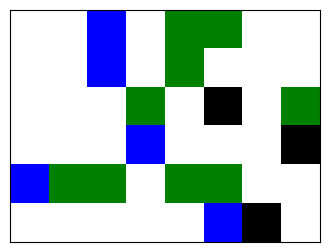

In [63]:


# Create animation
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xticks([])
ax.set_yticks([])
# maybe humo
# espacio vacío = blanco, Fuego = verde, POI = black, agente = azul, agente = yellow



colors = ['white', 'green', 'black', 'blue', 'yellow',
          'lightcoral', 'lightcoral']
cmap = matplotlib.colors.ListedColormap(colors)

# Update the vmax to account for the new maximum value (9)
patch = plt.imshow(all_grids.iloc[0]['Grid'], cmap=cmap, vmin=0, vmax=10)

def animate(i):
    patch.set_data(all_grids.iloc[i]['Grid'])

anim = animation.FuncAnimation(fig, animate, frames=model.steps)
caca = animation.FuncAnimation(fig, animate, frames=model.steps)
anim